In [15]:
from pathlib import Path

import pandas as pd
from tqdm.auto import tqdm
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem.FilterCatalog import FilterCatalog, FilterCatalogParams

In [16]:
# define paths
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [17]:
#### load data 
egfr_data = pd.read_csv(DATA / "EGFR_compounds_lipinski.csv",index_col=0,)
# Drop unnecessary information
print("Dataframe shape:", egfr_data.shape)
egfr_data.drop(columns=["molecular_weight", "n_hbd", "n_hba", "logp"], inplace=True)
egfr_data.head()

Dataframe shape: (5431, 10)


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled
0,CHEMBL63786,0.003,nM,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879,True
1,CHEMBL35820,0.006,nM,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849,True
2,CHEMBL53711,0.006,nM,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849,True
3,CHEMBL53753,0.008,nM,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910,True
4,CHEMBL66031,0.008,nM,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910,True


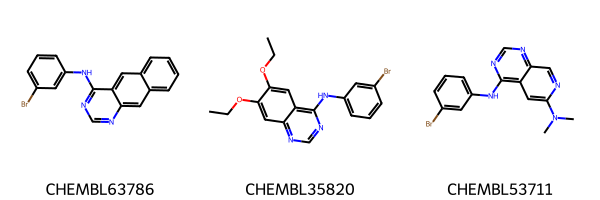

In [18]:
# Add molecule column
PandasTools.AddMoleculeColumnToFrame(egfr_data, smilesCol="smiles")
# Draw first 3 molecules
Chem.Draw.MolsToGridImage(
    list(egfr_data.head(3).ROMol),
    legends=list(egfr_data.head(3).molecule_chembl_id),
)

In [19]:
#### Filter for PAINS
'''
PAINS are compounds that often occur as hits in HTS even though they actually are false positives. 
PAINS show activity at numerous targets rather than one specific target. 
Such behavior results from unspecific binding or interaction with assay components.
'''
# initialize filter
params = FilterCatalogParams()
params.AddCatalog(FilterCatalogParams.FilterCatalogs.PAINS)
catalog = FilterCatalog(params)

In [20]:
# search for PAINS
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    entry = catalog.GetFirstMatch(molecule)  # Get the first matching PAINS
    if entry is not None:
        # store PAINS information
        matches.append(
            {
                "chembl_id": row.molecule_chembl_id,
                "rdkit_molecule": molecule,
                "pains": entry.GetDescription().capitalize(),
            }
        )
    else:
        # collect indices of molecules without PAINS
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]  # keep molecules without PAINS

  0%|          | 0/5431 [00:00<?, ?it/s]

In [21]:
print(f"Number of compounds with PAINS: {len(matches)}")
print(f"Number of compounds without PAINS: {len(egfr_data)}")
matches

Number of compounds with PAINS: 490
Number of compounds without PAINS: 4941


,chembl_id,rdkit_molecule,pains
0,CHEMBL5220645,<rdkit.Chem.rdchem.Mol object at 0x1132f3f40>,Anil_di_alk_g(9)
1,CHEMBL93032,<rdkit.Chem.rdchem.Mol object at 0x1132f3d10>,Catechol_a(92)
2,CHEMBL5191510,<rdkit.Chem.rdchem.Mol object at 0x1132f3d80>,Mannich_a(296)
3,CHEMBL4858583,<rdkit.Chem.rdchem.Mol object at 0x1132f3a00>,Azo_a(324)
4,CHEMBL2029429,<rdkit.Chem.rdchem.Mol object at 0x1132f3ed0>,Anil_di_alk_a(478)
...,...,...,...
485,CHEMBL145,<rdkit.Chem.rdchem.Mol object at 0x1132e3ae0>,Catechol_a(92)
486,CHEMBL57663,<rdkit.Chem.rdchem.Mol object at 0x1132e3b50>,Ene_cyano_a(19)
487,CHEMBL294681,<rdkit.Chem.rdchem.Mol object at 0x1132e3920>,Ene_cyano_a(19)
488,CHEMBL294213,<rdkit.Chem.rdchem.Mol object at 0x1132e38b0>,Ene_cyano_a(19)


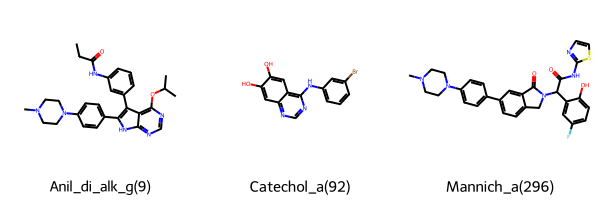

In [8]:
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    legends=list(matches.head(3)["pains"]),
)

In [9]:
####  Filter and highlight unwanted substructures
'''
Some lists of unwanted substructures, like PAINS, are already implemented in RDKit.
'''
substructures = pd.read_csv(DATA / "unwanted_substructures.csv", sep="\s+")
substructures["rdkit_molecule"] = substructures.smarts.apply(Chem.MolFromSmarts)
print("Number of unwanted substructures in collection:", len(substructures))
substructures

Number of unwanted substructures in collection: 104


,name,smarts,rdkit_molecule
0,>2EsterGroups,"C(=O)O[C,H1].C(=O)O[C,H1].C(=O)O[C,H1]",<rdkit.Chem.rdchem.Mol object at 0x1133ea650>
1,2-haloPyridine,"n1c([F,Cl,Br,I])cccc1",<rdkit.Chem.rdchem.Mol object at 0x1133ea570>
2,acidHalide,"C(=O)[Cl,Br,I,F]",<rdkit.Chem.rdchem.Mol object at 0x1133ea6c0>
3,acyclic-C=C-O,C=[C!r]O,<rdkit.Chem.rdchem.Mol object at 0x1133eac70>
4,acylCyanide,N#CC(=O),<rdkit.Chem.rdchem.Mol object at 0x1133ea7a0>
...,...,...,...
99,thiol,[SH],<rdkit.Chem.rdchem.Mol object at 0x1133f9380>
100,Three-membered-heterocycle,"*1[O,S,N]*1",<rdkit.Chem.rdchem.Mol object at 0x1133f93f0>
101,triflate,OS(=O)(=O)C(F)(F)F,<rdkit.Chem.rdchem.Mol object at 0x1133f9460>
102,triphenyl-methylsilyl,"[SiR0,CR0](c1ccccc1)(c2ccccc2)(c3ccccc3)",<rdkit.Chem.rdchem.Mol object at 0x1133f94d0>


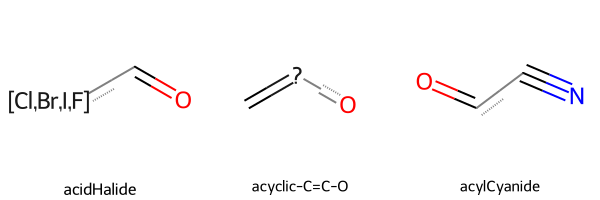

In [10]:
Chem.Draw.MolsToGridImage(
    mols=substructures.rdkit_molecule.tolist()[2:5],
    legends=substructures.name.tolist()[2:5],
)

In [11]:
# search for unwanted substructure
matches = []
clean = []
for index, row in tqdm(egfr_data.iterrows(), total=egfr_data.shape[0]):
    molecule = Chem.MolFromSmiles(row.smiles)
    match = False
    for _, substructure in substructures.iterrows():
        if molecule.HasSubstructMatch(substructure.rdkit_molecule):
            matches.append(
                {
                    "chembl_id": row.molecule_chembl_id,
                    "rdkit_molecule": molecule,
                    "substructure": substructure.rdkit_molecule,
                    "substructure_name": substructure["name"],
                }
            )
            match = True
    if not match:
        clean.append(index)

matches = pd.DataFrame(matches)
egfr_data = egfr_data.loc[clean]

  0%|          | 0/4941 [00:00<?, ?it/s]

In [12]:
print(f"Number of found unwanted substructure: {len(matches)}")
print(f"Number of compounds without unwanted substructure: {len(egfr_data)}")
matches

Number of found unwanted substructure: 3826
Number of compounds without unwanted substructure: 2397


,chembl_id,rdkit_molecule,substructure,substructure_name
0,CHEMBL63786,<rdkit.Chem.rdchem.Mol object at 0x1132f5a10>,<rdkit.Chem.rdchem.Mol object at 0x1133f8a50>,Polycyclic-aromatic-hydrocarbon
1,CHEMBL1243316,<rdkit.Chem.rdchem.Mol object at 0x1132f57e0>,<rdkit.Chem.rdchem.Mol object at 0x1133eaab0>,Aliphatic-long-chain
2,CHEMBL1243316,<rdkit.Chem.rdchem.Mol object at 0x1132f57e0>,<rdkit.Chem.rdchem.Mol object at 0x1133f8120>,Michael-acceptor
3,CHEMBL1243316,<rdkit.Chem.rdchem.Mol object at 0x1132f57e0>,<rdkit.Chem.rdchem.Mol object at 0x1133f9540>,triple-bond
4,CHEMBL3613702,<rdkit.Chem.rdchem.Mol object at 0x1132f5af0>,<rdkit.Chem.rdchem.Mol object at 0x1133eba70>,halogenated-ring
...,...,...,...,...
3821,CHEMBL308133,<rdkit.Chem.rdchem.Mol object at 0x1133d1930>,<rdkit.Chem.rdchem.Mol object at 0x1133f8120>,Michael-acceptor
3822,CHEMBL308133,<rdkit.Chem.rdchem.Mol object at 0x1133d1930>,<rdkit.Chem.rdchem.Mol object at 0x1133f8270>,Michael-acceptor
3823,CHEMBL75718,<rdkit.Chem.rdchem.Mol object at 0x1133d19a0>,<rdkit.Chem.rdchem.Mol object at 0x1133eb1b0>,conjugated-nitrile-group
3824,CHEMBL66879,<rdkit.Chem.rdchem.Mol object at 0x1133d1a10>,<rdkit.Chem.rdchem.Mol object at 0x1133f8120>,Michael-acceptor


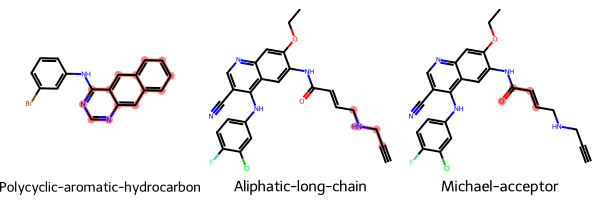

In [13]:
to_highlight = [
    row.rdkit_molecule.GetSubstructMatch(row.substructure) for _, row in matches.head(3).iterrows()
]
Chem.Draw.MolsToGridImage(
    list(matches.head(3).rdkit_molecule),
    highlightAtomLists=to_highlight,
    legends=list(matches.head(3).substructure_name),
)

In [14]:
groups = matches.groupby("substructure_name")
group_frequencies = groups.size()
group_frequencies.sort_values(ascending=False, inplace=True)
group_frequencies.head(10)

substructure_name
Michael-acceptor               1328
Aliphatic-long-chain            546
Oxygen-nitrogen-single-bond     446
triple-bond                     293
nitro-group                     194
imine                           187
Thiocarbonyl-group              124
aniline                          81
hydroxamic-acid                  79
halogenated-ring                 75
dtype: int64